# Describe data used after applying models (HETDEX and Stripe 82)

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mpl_scatter_density
from sklearn.model_selection import train_test_split
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from scipy.ndimage import gaussian_filter
import colorcet as cc
import cmasher as cmr
import pandas as pd
from chainconsumer import ChainConsumer
import global_variables as gv
import global_functions as gf

In [2]:
def radio_lum(flux, z, alpha):  # Output in W Hz-1
    lum_dist = cosmo.luminosity_distance(z).to(u.m)
    num      = 4 * np.pi * flux.to(u.Jy) * lum_dist**2
    denom    = (1 + z)**(alpha +1)
    return (num/denom).to(u.W / u.Hz)

In [3]:
def radio_lum_dist(flux, z, lum_dist, alpha):  # Output in W Hz-1
    num      = 4 * np.pi * flux.to(u.Jy) * lum_dist**2
    denom    = (1 + z)**(alpha +1)
    return (num/denom).to(u.W / u.Hz)

In [4]:
def clean_and_smooth_matrix(matrix, sigma=0.9):
    matrix[~np.isfinite(matrix)] = 0
    matrix_smooth = gaussian_filter(matrix, sigma=0.9)
    matrix_smooth[~np.isfinite(matrix_smooth)] = 0
    return matrix_smooth

In [5]:
def pad_matrix_zeros(matrix, xedges, yedges):  # Pads matrices and creates centred edges
    x_centres = 0.5 * (xedges[:-1] + xedges[1:])
    y_centres = 0.5 * (yedges[:-1] + yedges[1:])
    matrix    = np.pad(matrix, ((1, 1), (1, 1)), mode='constant', constant_values=(0,))
    x_centres = np.pad(x_centres, (1, 1), mode='constant', constant_values=(xedges[0], xedges[-1]))
    y_centres = np.pad(y_centres, (1, 1), mode='constant', constant_values=(yedges[0], yedges[-1]))
    return matrix, x_centres, y_centres

In [6]:
def cut_rgb_val(val):
    if val < 0.0:
        return 0.0
    if val > 1.0:
        return 1.0
    else:
        return val

In [7]:
def fmt(x):
    x = x * 100.
    x = 100. - x
    s = f'{x:.2f}'
    if s.endswith('0'):
        s = f'{x:.0f}'
    return rf'${s} \%$' if plt.rcParams['text.usetex'] else f'{s} %'

In [71]:
def create_colour_gradient(colour_hex):
    colour_rgb = mcolors.to_rgb(colour_hex)
    colour_rgb_darker = list(colour_rgb)
    colour_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rgb)])
    colour_rgb_darker = list([value * 0.7 for value in colour_rgb_darker])
    colour_rgb_bright = tuple(colour_rgb_bright)
    colour_rgb_darker = tuple(colour_rgb_darker)
    colours      = [colour_rgb_darker, colour_rgb_bright] # first color is darker
    cm_gradient = mcolors.LinearSegmentedColormap.from_list(f'gradient_{colour_hex}', colours, N=50)
    return cm_gradient

In [8]:
mpl.rcdefaults()

In [9]:
plt.rcParams['text.usetex'] = True

In [10]:
radio_alpha         = -0.8

In [11]:
limit_flux_HETDEX   = 71e-6  # 71 uJy
limit_flux_S82      = 52e-6  # 52 uJy

In [12]:
colour_hex_rGal = '#1E88E5'
colour_hex_rAGN = '#D32F2F'

colour_rGal = mcolors.to_rgba(colour_hex_rGal)
colour_rAGN = mcolors.to_rgba(colour_hex_rAGN)

colour_rGal_rgb = mcolors.to_rgb(colour_hex_rGal)
colour_rAGN_rgb = mcolors.to_rgb(colour_hex_rAGN)

colour_rGal_shade = list(colour_rGal)
colour_rAGN_shade = list(colour_rAGN)

colour_rGal_shade[3] = 0.6
colour_rAGN_shade[3] = 0.6

colour_rGal_shade = tuple(colour_rGal_shade)
colour_rAGN_shade = tuple(colour_rAGN_shade)

In [13]:
colour_rGal_rgb_darker = list(colour_rGal_rgb)
colour_rAGN_rgb_darker = list(colour_rAGN_rgb)

colour_rGal_rgb_darker = list([value * 0.7 for value in colour_rGal_rgb_darker])
colour_rAGN_rgb_darker = list([value * 0.7 for value in colour_rAGN_rgb_darker])

colour_rGal_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rGal_rgb)])
colour_rAGN_rgb_bright = list([cut_rgb_val(value * 1.5) for value in list(colour_rAGN_rgb)])

colour_rGal_rgb_darker = tuple(colour_rGal_rgb_darker)
colour_rAGN_rgb_darker = tuple(colour_rAGN_rgb_darker)
colour_rGal_rgb_bright = tuple(colour_rGal_rgb_bright)
colour_rAGN_rgb_bright = tuple(colour_rAGN_rgb_bright)

In [14]:
colors_rAGN      = [colour_rAGN_rgb_darker, colour_rAGN_rgb_bright] # first color is darker
cm_gradient_rAGN = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN', colors_rAGN, N=50)

colors_rGal      = [colour_rGal_rgb_darker, colour_rGal_rgb_bright] # first color is darker
cm_gradient_rGal = mcolors.LinearSegmentedColormap.from_list('gradient_rGal', colors_rGal, N=50)

cm_gradient      = {'rAGN': cm_gradient_rAGN, 'rGal': cm_gradient_rGal}

---

## Reading data

#### File name

In [15]:
save_plot_flag      = False
use_imputed         = False
plot_area_dens      = True

In [16]:
used_area           = 'S82'  # can be 'S82', 'HETDEX'
HETDEX_subset       = 'all'  # 'training', 'test', 'train_test', 'calibration', 'validation', 'known', 'unknown', 'all'
S82_subset          = 'all'  # 'known', 'unknown', 'all'

In [17]:
if plot_area_dens:
    norm_str            = '_norm'
if not plot_area_dens:
    norm_str            = ''

In [18]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'W1mag', 'W2mag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]
if not use_imputed:
    feats_2_disc_HETDEX.remove('num_imputed')
    feats_2_disc_S82.remove('num_imputed')

In [19]:
if use_imputed:
    file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
    imp_string          = '_imputed'
if not use_imputed:
    file_name_dict      = {'S82': gv.file_non_imp_S82, 'HETDEX': gv.file_non_imp_HETDEX, 'COSMOS': gv.file_non_imp_COSMOS}
    imp_string          = '_nonimputed'
file_name               = file_name_dict[used_area]

if plot_area_dens:
    norm_str            = '_norm'
if not plot_area_dens:
    norm_str            = ''

In [20]:
# full_catalog_HETDEX_df  = pd.read_csv(gv.preds_path + f'predicted_rAGN_HETDEX.csv')
# full_catalog_S82_df     = pd.read_csv(gv.preds_path + f'predicted_rAGN_S82.csv')

In [21]:
# full_catalog_HETDEX_df = pd.read_parquet(gv.preds_path + 'HETDEX_full_prediction.parquet',
#                                          engine='fastparquet', columns=feats_2_use)
full_catalog_HETDEX_df = pd.read_parquet(gv.preds_path + 'HETDEX_full_prediction.parquet',
                                         engine='fastparquet')
full_catalog_S82_df    = pd.read_parquet(gv.preds_path + 'S82_full_prediction.parquet',
                                         engine='fastparquet')

In [22]:
np.array(full_catalog_HETDEX_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_AB', 'Sint_LOFAR_non_imp', 'rms_LOFAR',
       'Speak_LOFAR', 'Speak_LOFAR_non_imp', 'is_str', 'W1mproPM',
       'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J',
       'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y',
       'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y',
       'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J',
       'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K',
       'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2',
       'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1',
       'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'radio_detect', 'LOFAR_detect', 'class',
       'radio_AGN', 'Prob_AGN', 'Prob_radio_AGN', 'Prob_radio_gal',
       'pred_Z_rAGN

In [23]:
np.array(full_catalog_S82_df.columns)

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Fint_VLAS82', 'Fint_VLAS82_AB', 'Fint_VLAS82_non_imp',
       'rms_VLAS82', 'is_str', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag',
       'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag',
       'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2',
       'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1',
       'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1',
       'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2',
       'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3',
       'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K',
       'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4',
       'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4',
       'radio_detect', 'LOFAR_detect', 'class', 'radio_AGN', 'Prob_AGN',
       'Prob_radio_AGN', 'Prob_radio_gal', 'pred_Z_rAGN', 'pred_Z_rGal',
       'pred_class_cal'

Convert values from `float64` to `float32`.

In [24]:
#for col in full_catalog_HETDEX_df.columns:
#    if full_catalog_HETDEX_df.loc[:, col].dtype == 'float64':
#        full_catalog_HETDEX_df.loc[:, col] = full_catalog_HETDEX_df.loc[:, col].astype('float32')
#for col in full_catalog_S82_df.columns:
#    if full_catalog_S82_df.loc[:, col].dtype == 'float64':
#        full_catalog_S82_df.loc[:, col] = full_catalog_S82_df.loc[:, col].astype('float32')

In [25]:
true_HETDEX_AGN_filter       = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1)
true_S82_AGN_filter          = np.array(full_catalog_S82_df.loc[:, 'class'] == 1)
true_HETDEX_gal_filter       = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0)
true_S82_gal_filter          = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)

In [26]:
true_HETDEX_radio_filter     = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1)
true_S82_radio_filter        = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1)
true_HETDEX_noradio_filter   = np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 0)
true_S82_noradio_filter      = np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 0)

In [27]:
pred_HETDEX_AGN_filter      = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1)
pred_S82_AGN_filter         = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 1)
pred_HETDEX_gal_filter      = np.array(full_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 0)
pred_S82_gal_filter         = np.array(full_catalog_S82_df.loc[:, 'pred_class_cal'] == 0)

In [28]:
pred_HETDEX_AGN_radio_filter   = pred_HETDEX_AGN_filter &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal_AGN'] == 1)
pred_S82_AGN_radio_filter      = pred_S82_AGN_filter &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal_AGN'] == 1)
pred_HETDEX_AGN_noradio_filter = pred_HETDEX_AGN_filter &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal_AGN'] == 0)
pred_S82_AGN_noradio_filter    = pred_S82_AGN_filter &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal_AGN'] == 0)

In [29]:
pred_HETDEX_gal_radio_filter   = pred_HETDEX_gal_filter &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal_gal'] == 1)
pred_S82_gal_radio_filter      = pred_S82_gal_filter &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal_gal'] == 1)
pred_HETDEX_gal_noradio_filter = pred_HETDEX_gal_filter &\
                                np.array(full_catalog_HETDEX_df.loc[:, 'pred_radio_cal_gal'] == 0)
pred_S82_gal_noradio_filter    = pred_S82_gal_filter &\
                                np.array(full_catalog_S82_df.loc[:, 'pred_radio_cal_gal'] == 0)

In [30]:
known_HETDEX_filter     = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0) |\
                            np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1)
known_S82_filter        = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)    |\
                            np.array(full_catalog_S82_df.loc[:, 'class'] == 1)

In [31]:
true_HETDEX_rAGN_filter = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 1) &\
                            np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1)
true_S82_rAGN_filter    = np.array(full_catalog_S82_df.loc[:, 'class'] == 1)    &\
                            np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1)

In [32]:
true_HETDEX_rGal_filter = np.array(full_catalog_HETDEX_df.loc[:, 'class'] == 0) &\
                            np.array(full_catalog_HETDEX_df.loc[:, 'radio_detect'] == 1)
true_S82_rGal_filter    = np.array(full_catalog_S82_df.loc[:, 'class'] == 0)    &\
                            np.array(full_catalog_S82_df.loc[:, 'radio_detect'] == 1)

In [33]:
# HETDEX_pred_rAGN_filter = np.array(full_catalog_HETDEX_df.loc[:, 'pred_prob_class'] == 1) &\
#                             np.array(full_catalog_HETDEX_df.loc[:, 'pred_prob_radio'] == 1)
# S82_pred_rAGN_filter    = np.array(full_catalog_S82_df.loc[:, 'pred_prob_class'] == 1)    &\
#                             np.array(full_catalog_S82_df.loc[:, 'pred_prob_radio'] == 1)

In [34]:
# HETDEX_pred_AGN_norad_filter = np.array(full_catalog_HETDEX_df.loc[:, 'pred_prob_class'] == 1) &\
#                                 np.array(full_catalog_HETDEX_df.loc[:, 'pred_prob_radio'] == 0)
# S82_pred_AGN_norad_filter    = np.array(full_catalog_S82_df.loc[:, 'pred_prob_class'] == 1)    &\
#                                 np.array(full_catalog_S82_df.loc[:, 'pred_prob_radio'] == 0)

In [35]:
if HETDEX_subset == 'unknown':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[~HETDEX_known_filter]
elif HETDEX_subset == 'known':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
elif HETDEX_subset == 'training':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, full_catalog_HETDEX_df, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],
                                                      'class', use_calibration=True)
elif HETDEX_subset == 'test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, full_catalog_HETDEX_df, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],
                                                      'class', use_calibration=True)
elif HETDEX_subset == 'train_test':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    full_catalog_HETDEX_df, _, _, _, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],
                                                      'class', use_calibration=True)
elif HETDEX_subset == 'calibration':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, full_catalog_HETDEX_df, _ = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],
                                                      'class', use_calibration=True)
elif HETDEX_subset == 'validation':
    full_catalog_HETDEX_df = full_catalog_HETDEX_df.loc[HETDEX_known_filter]
    _, _, _, _, full_catalog_HETDEX_df = gf.split_set(full_catalog_HETDEX_df, [0.2, 0.2, 0.5],
                                                      'class', use_calibration=True)
else:
    pass

In [36]:
if S82_subset == 'unknown':
    full_catalog_S82_df = full_catalog_S82_df.loc[~S82_known_filter]
elif S82_subset == 'known':
    full_catalog_S82_df = full_catalog_S82_df.loc[S82_known_filter]
else:
    pass

In [37]:
print('Shape of used data in HETDEX')
print('-' * 40)
print(f'Selected sub-set is: {HETDEX_subset}')
print(f'Its shape is:        {full_catalog_HETDEX_df.shape}')
print('-' * 40)
print()

Shape of used data in HETDEX
----------------------------------------
Selected sub-set is: all
Its shape is:        (15136878, 108)
----------------------------------------



In [38]:
print('Shape of used data in Stripe 82')
print('-' * 40)
print(f'Selected sub-set is: {S82_subset}')
print(f'Its shape is:        {full_catalog_S82_df.shape}')
print('-' * 40)
print()

Shape of used data in Stripe 82
----------------------------------------
Selected sub-set is: all
Its shape is:        (3590306, 106)
----------------------------------------



---

Produce combined redshift values

In [39]:
pred_z_col = 'pred_Z'
true_z_col = 'Z'
full_catalog_HETDEX_df[pred_z_col] = full_catalog_HETDEX_df.loc[:, 'pred_Z_rAGN']
full_catalog_S82_df[pred_z_col]    = full_catalog_S82_df.loc[:, 'pred_Z_rAGN']

full_catalog_HETDEX_df.loc[pred_HETDEX_gal_filter, pred_z_col] = full_catalog_HETDEX_df.loc[:, 'pred_Z_rGal']
full_catalog_S82_df.loc[pred_S82_gal_filter, pred_z_col]       = full_catalog_S82_df.loc[:, 'pred_Z_rGal']

## Description plots

In [40]:
bands_plot = ['gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag',
              'Hmag', 'Kmag', 'W1mproPM', 'W2mproPM', 'W3mag', 'W4mag']

In [41]:
mag_cols_lim = {'W1mproPM': 20.13, 'W2mproPM': 19.81, 'Sint_LOFAR': 17.52, 'Total_flux_VLASS': 15.21,\
                    'TotalFlux_LoLSS': 12.91, 'Stotal_TGSS': 11.18, 'Fint_VLAS82': 17.86,\
                    'Flux_COSMOSVLA3': 21.25, 'W1mag': 19.6, 'W2mag': 19.34, 'W3mag': 16.67,\
                    'W4mag': 14.62, 'gmag': 23.3, 'rmag': 23.2, 'imag': 23.1, 'zmag': 22.3,\
                    'ymag': 21.4, 'FUVmag': 20.0, 'NUVmag': 21.0, 'FEP': 57.9, 'Jmag': 17.45,\
                    'Hmag': 17.24, 'Kmag': 16.59}  # Proper (5-sigma) limits

for key in mag_cols_lim:
    mag_cols_lim[key] = np.float32(mag_cols_lim[key])

In [77]:
vega_shift   = {'W1mproPM': 2.699, 'W2mproPM': 3.339, 'W1mag': 2.699, 'W2mag': 3.339,
                'W3mag': 5.174, 'W4mag': 6.620, 'Jmag': 0.910, 'Hmag': 1.390, 
                'Kmag': 1.850, 'gmag': 0.4810, 'rmag': 0.6170, 'imag': 0.7520, 
                'zmag': 0.8660, 'ymag': 0.9620}

In [42]:
mag_cols_names   = {'W1mproPM': 'W1', 'W2mproPM': 'W2', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3', 'W4mag': 'W4', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

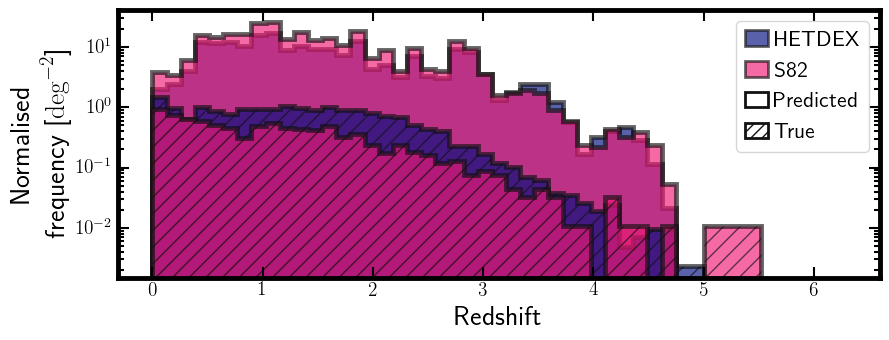

In [43]:
fig             = plt.figure(figsize=(9,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_z_HETDEX_pred = full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter * ~known_HETDEX_filter, pred_z_col].min()
max_z_HETDEX_pred = full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter * ~known_HETDEX_filter, pred_z_col].max()
min_z_HETDEX_true = full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter * known_HETDEX_filter, 'Z'].min()
max_z_HETDEX_true = full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter * known_HETDEX_filter, 'Z'].max()
min_z_S82_pred    = full_catalog_S82_df.loc[pred_S82_AGN_radio_filter * ~known_S82_filter, pred_z_col].min()
max_z_S82_pred    = full_catalog_S82_df.loc[pred_S82_AGN_radio_filter * ~known_S82_filter, pred_z_col].max()
min_z_S82_true    = full_catalog_S82_df.loc[pred_S82_AGN_radio_filter * known_S82_filter, 'Z'].min()
max_z_S82_true    = full_catalog_S82_df.loc[pred_S82_AGN_radio_filter * known_S82_filter, 'Z'].max()
full_z_bins       = np.linspace(np.nanmin([min_z_HETDEX_pred, min_z_HETDEX_true, min_z_S82_pred, min_z_S82_true]),\
                                np.nanmax([max_z_HETDEX_pred, max_z_HETDEX_true, max_z_S82_pred, max_z_S82_true]), 50)

counts_HETDEX_pred, edges_HETDEX_pred = np.histogram(full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter * ~known_HETDEX_filter, pred_z_col], bins=full_z_bins)
counts_S82_pred,    edges_S82_pred    = np.histogram(full_catalog_S82_df.loc[pred_S82_AGN_radio_filter * ~known_S82_filter, pred_z_col], bins=full_z_bins)
counts_HETDEX_true, edges_HETDEX_true = np.histogram(full_catalog_HETDEX_df.loc[true_HETDEX_rAGN_filter * known_HETDEX_filter, 'Z'], bins=full_z_bins)
counts_S82_true,    edges_S82_true    = np.histogram(full_catalog_S82_df.loc[true_S82_rAGN_filter * known_S82_filter, 'Z'], bins=full_z_bins)

ax1.stairs(counts_HETDEX_pred / gv.area_HETDEX, edges_HETDEX_pred, fill=True, 
           ec='k', lw=3.5,fc=plt.get_cmap('cet_bmy',3)(0.0), label='HETDEX', alpha=0.65)
ax1.stairs(counts_S82_pred / gv.area_S82, edges_S82_pred, fill=True, ec='k', 
           lw=3.5, fc=plt.get_cmap('cet_bmy',3)(0.5), label='S82', alpha=0.65)
ax1.stairs(counts_HETDEX_true / gv.area_HETDEX, edges_HETDEX_true, fill=True, ec='k', 
           lw=3.5, fc=plt.get_cmap('cet_bmy',3)(0.0), label='HETDEX', hatch='//', alpha=0.65)
ax1.stairs(counts_S82_true / gv.area_S82, edges_S82_true, fill=True, ec='k', lw=3.5, 
           fc=plt.get_cmap('cet_bmy',3)(0.5), label='S82', hatch='//', alpha=0.65)


HETDEX_patch       = mpatches.Patch(fc=plt.get_cmap('cet_bmy',3)(0.0), ec='k', 
                                    label='HETDEX', lw=2.0, alpha=0.65)
S82_patch          = mpatches.Patch(fc=plt.get_cmap('cet_bmy',3)(0.5), ec='k', 
                                    label='S82', lw=2.0, alpha=0.65)
pred_patch         = mpatches.Patch(fc='None', ec='k', label='Predicted', lw=2.0)
true_patch         = mpatches.Patch(fc='None', ec='k', label='True', hatch='///', lw=2.0)
ax1.legend(handles=[HETDEX_patch, S82_patch, pred_patch, true_patch], loc=1, 
           fontsize=16, ncol=1, handletextpad=0.3, handlelength=1.0, columnspacing=0.5)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Normalised\nfrequency [$\mathrm{deg}^{-2}$]', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
# plt.legend(loc=1, fontsize=14)
# ax1.set_xlim(left=2.8, right=20.2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_pred_true_z_HETDEX_{HETDEX_subset}_S82{imp_string}.pdf', bbox_inches='tight')
plt.show()

Repeat previous plot (colour-colour) but with highly-relevant features from models.

In [44]:
mag_cols_names   = {'W1': 'W1mproPM', 'W2': 'W2mproPM', 'W3': 'W3mag', 'W4': 'W4mag',
                    'g': 'gmag', 'r': 'rmag', 'i': 'imag', 'z': 'zmag', 'y': 'ymag',
                    'J': 'Jmag', 'H': 'Hmag', 'K': 'Kmag'}

In [45]:
colours_list   = ['W1_W2', 'r_z', 'g_r', 'W1_W3', 'y_W2', 'g_J', 'r_i', 'r_W1', 
                  'i_y', 'z_y', 'i_z', 'y_J', 'K_W3', 'H_K', 'J_H', 'W2_W3', 'z_W1', 
                  'y_W1', 'K_W4', 'g_W1']

In [46]:
# cols_pairplot = ['band_num', 'W4mag', 'Kmag', 'g_r', 'g_i', 'g_J', 
#                  'r_i', 'r_z',  'r_J', 'r_W1', 'i_z', 'i_y', 
#                  'z_y', 'z_W1', 'y_J', 'y_W1', 'y_W2',  'J_H', 
#                  'K_W3', 'K_W4', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 
#                 'W2_W3', 'W3_W4', 'pred_Z']  # All features used in three models plus predicted redshift

cols_AGN   = ['g_r', 'r_i', 'r_J', 'i_z', 'i_y', 
              'z_y', 'z_W2', 'y_J', 'y_W1', 'y_W2', 'J_H', 'H_K',  
              'H_W3', 'W1_W2', 'W1_W3', 'W3_W4']  #  Only colours (no 'band_num', 'W4mag')
cols_radio = ['g_r', 'g_i', 'r_i', 'r_z', 'i_z',  
              'z_y', 'z_W1', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3',  
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')
cols_z     = ['g_r', 'g_W3', 'r_i', 'r_z', 'i_z', 
              'i_y', 'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 
              'K_W4', 'W1_W2', 'W2_W3']  # Only colours (no 'band_num', 'W4mag')

colours_list  = list(np.unique(cols_AGN + cols_radio + cols_z))
    
cols_pairplot = ['band_num', 'W4mag'] + colours_list  # All features used in three models plus predicted redshift

Create colours

In [47]:
# for colour in colours_list:
#     full_catalog_HETDEX_df[colour] = full_catalog_HETDEX_df.loc[:, mag_cols_names[colour.split('_')[0]]] -\
#                                     full_catalog_HETDEX_df.loc[:, mag_cols_names[colour.split('_')[1]]]
#     full_catalog_S82_df[colour] = full_catalog_S82_df.loc[:, mag_cols_names[colour.split('_')[0]]] -\
#                                     full_catalog_S82_df.loc[:, mag_cols_names[colour.split('_')[1]]]

Plot histograms (distributions) from all features separated by target (classification)

Obtain radio luminosities

In [48]:
lums_dist_HETDEX = cosmo.luminosity_distance(full_catalog_HETDEX_df.loc[:, pred_z_col].values).to(u.m)
lums_dist_S82    = cosmo.luminosity_distance(full_catalog_S82_df.loc[:, pred_z_col].values).to(u.m)
full_catalog_HETDEX_df['lum_dist_m'] = lums_dist_HETDEX.value
full_catalog_S82_df['lum_dist_m']    = lums_dist_S82.value

In [49]:
lums_orig_HETDEX = radio_lum_dist(full_catalog_HETDEX_df.loc[:, 'Sint_LOFAR_non_imp'].values * u.mJy,
                        full_catalog_HETDEX_df.loc[:, pred_z_col].values, lums_dist_HETDEX, radio_alpha)
lums_orig_S82    = radio_lum_dist(full_catalog_S82_df.loc[:, 'Fint_VLAS82_non_imp'].values * u.mJy,
                        full_catalog_S82_df.loc[:, pred_z_col].values, lums_dist_S82, radio_alpha)  # Assuming same alpha as AGN
full_catalog_HETDEX_df['lum_orig'] = lums_orig_HETDEX.value
full_catalog_S82_df['lum_orig']    = lums_orig_S82.value

In [50]:
true_lums_orig_HETDEX = radio_lum_dist(full_catalog_HETDEX_df.loc[:, 'Sint_LOFAR_non_imp'].values * u.mJy,
                        full_catalog_HETDEX_df.loc[:, true_z_col].values, lums_dist_HETDEX, radio_alpha)
true_lums_orig_S82    = radio_lum_dist(full_catalog_S82_df.loc[:, 'Fint_VLAS82_non_imp'].values * u.mJy,
                        full_catalog_S82_df.loc[:, true_z_col].values, lums_dist_S82, radio_alpha)  # Assuming same alpha as AGN
full_catalog_HETDEX_df['true_lum_orig'] = true_lums_orig_HETDEX.value
full_catalog_S82_df['true_lum_orig']    = true_lums_orig_S82.value

In [51]:
lums_14_GHz_HETDEX = lums_orig_HETDEX * ((1.4 * u.GHz) / (144 * u.MHz).to(u.GHz)).value**radio_alpha
lums_14_GHz_S82    = lums_orig_S82

true_lums_14_GHz_HETDEX = true_lums_orig_HETDEX * ((1.4 * u.GHz) / (144 * u.MHz).to(u.GHz)).value**radio_alpha
true_lums_14_GHz_S82    = true_lums_orig_S82

full_catalog_HETDEX_df['lum_14_GHz']     = lums_14_GHz_HETDEX.value
full_catalog_S82_df['lum_14_GHz']        = lums_14_GHz_S82.value

full_catalog_HETDEX_df['log_lum_orig']    = np.log10(lums_orig_HETDEX.value)
full_catalog_S82_df['log_lum_orig']       = np.log10(lums_orig_S82.value)

full_catalog_HETDEX_df['log_lum_14_GHz'] = np.log10(lums_14_GHz_HETDEX.value)
full_catalog_S82_df['log_lum_14_GHz']    = np.log10(lums_14_GHz_S82.value)

full_catalog_HETDEX_df['true_lum_14_GHz']     = true_lums_14_GHz_HETDEX.value
full_catalog_S82_df['true_lum_14_GHz']        = true_lums_14_GHz_S82.value

full_catalog_HETDEX_df['log_true_lum_orig']    = np.log10(true_lums_orig_HETDEX.value)
full_catalog_S82_df['log_true_lum_orig']       = np.log10(true_lums_orig_S82.value)

full_catalog_HETDEX_df['log_true_lum_14_GHz'] = np.log10(true_lums_14_GHz_HETDEX.value)
full_catalog_S82_df['log_true_lum_14_GHz']    = np.log10(true_lums_14_GHz_S82.value)

Plot luminosities

In [52]:
rAGN_HETDEX_df = full_catalog_HETDEX_df.loc[pred_HETDEX_AGN_radio_filter & true_HETDEX_radio_filter]
rGal_HETDEX_df = full_catalog_HETDEX_df.loc[pred_HETDEX_gal_radio_filter & true_HETDEX_radio_filter]
rAGN_S82_df    = full_catalog_S82_df.loc[pred_S82_AGN_radio_filter & true_S82_radio_filter]
rGal_S82_df    = full_catalog_S82_df.loc[pred_S82_gal_radio_filter & true_S82_radio_filter]

In [53]:
true_rAGN_HETDEX_df = full_catalog_HETDEX_df.loc[true_HETDEX_AGN_filter & true_HETDEX_radio_filter]
true_rGal_HETDEX_df = full_catalog_HETDEX_df.loc[true_HETDEX_gal_filter & true_HETDEX_radio_filter]
true_rAGN_S82_df    = full_catalog_S82_df.loc[true_S82_AGN_filter & true_S82_radio_filter]
true_rGal_S82_df    = full_catalog_S82_df.loc[true_S82_gal_filter & true_S82_radio_filter]

In [54]:
nstep = 4
seq_cont   = np.logspace(-1.5, 0.0, nstep)
seq_cont   = np.insert(seq_cont, 0, 0.0)
seq_fill   = np.logspace(-1.5, 0.0, nstep+2)
seq_fill   = np.insert(seq_fill, 0, 0.0)

In [55]:
sigma_limit_HETDEX = 3
sigma_limit_S82    = 3

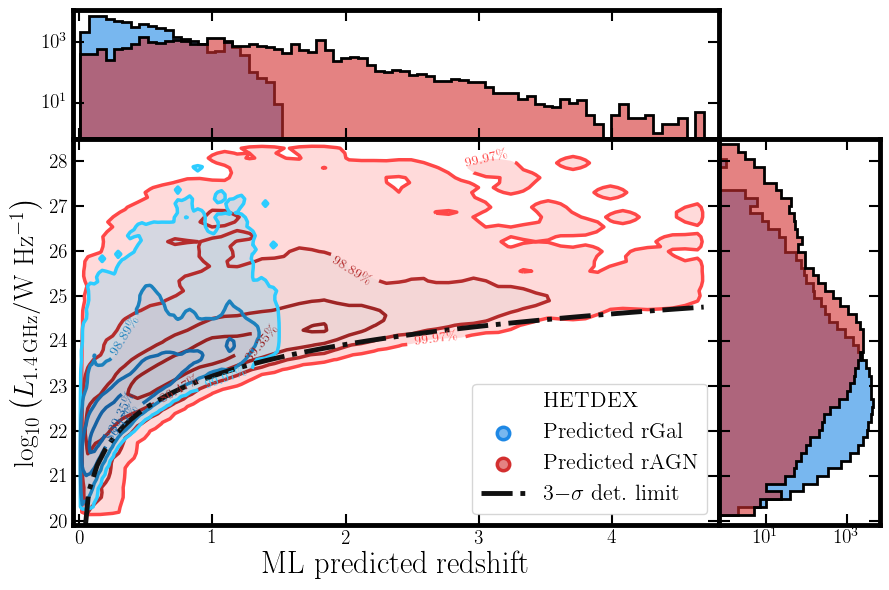

In [56]:
fig    = plt.figure(figsize=(9, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

min_z = np.nanmin(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, pred_z_col].values)
max_z = np.nanmax(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, pred_z_col].values)

min_lum  = np.nanmin(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, 'lum_14_GHz'].values)
max_lum  = np.nanmax(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, 'lum_14_GHz'].values)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(rGal_HETDEX_df.loc[:, pred_z_col], 
                                   rGal_HETDEX_df.loc[:, 'log_lum_14_GHz'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(rAGN_HETDEX_df.loc[:, pred_z_col], 
                                   rAGN_HETDEX_df.loc[:, 'log_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rGal, 
               color=colour_rGal_shade, s=80, 
               label='$\mathrm{Predicted ~ rGal}$', linewidths=2.5)
axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, 
               color=colour_rAGN_shade, s=80, 
               label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, 
            np.log10((radio_lum(sigma_limit_HETDEX * limit_flux_HETDEX * u.Jy, bins_z, radio_alpha) * ((1.4 * u.GHz) / (144 * u.MHz).to(u.GHz))**radio_alpha).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_HETDEX} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(rGal_HETDEX_df.loc[:, pred_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[0].hist(rAGN_HETDEX_df.loc[:, pred_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(np.log10(rGal_HETDEX_df.loc[:, 'lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(np.log10(rAGN_HETDEX_df.loc[:, 'lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=r'$\mathrm{HETDEX}$', title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{ML ~ predicted ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=19.9, top=28.5)
axs[1].set_xlim(left=-0.05, right=4.80)
plt.tight_layout()
plt.show()

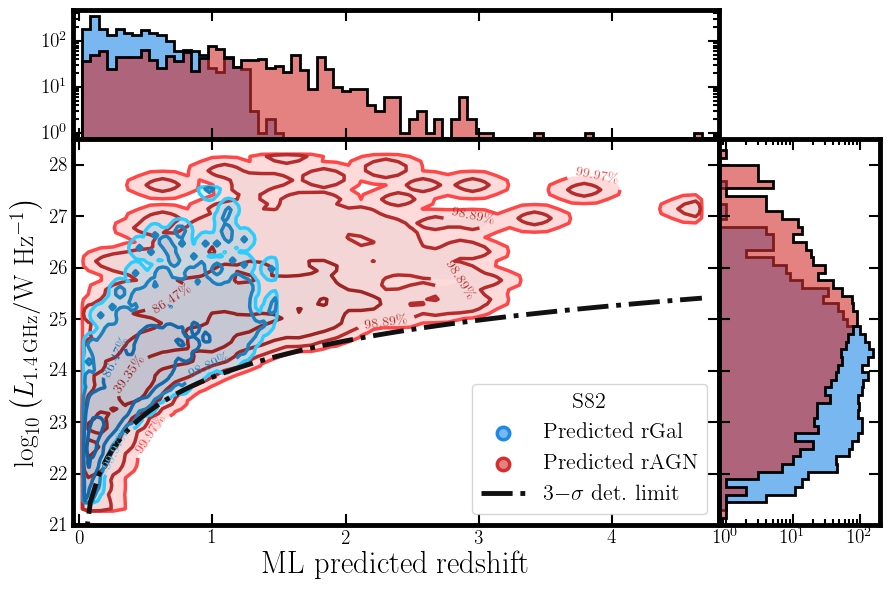

In [57]:
fig    = plt.figure(figsize=(9, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

min_z = np.nanmin(full_catalog_S82_df.loc[true_S82_radio_filter, pred_z_col].values)
max_z = np.nanmax(full_catalog_S82_df.loc[true_S82_radio_filter, pred_z_col].values)

min_lum  = np.nanmin(full_catalog_S82_df.loc[true_S82_radio_filter, 'lum_14_GHz'].values)
max_lum  = np.nanmax(full_catalog_S82_df.loc[true_S82_radio_filter, 'lum_14_GHz'].values)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(rGal_S82_df.loc[:, pred_z_col], 
                                   rGal_S82_df.loc[:, 'log_lum_14_GHz'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(rAGN_S82_df.loc[:, pred_z_col], 
                                   rAGN_S82_df.loc[:, 'log_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rGal, 
               color=colour_rGal_shade, s=80, 
               label='$\mathrm{Predicted ~ rGal}$', linewidths=2.5)
axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, 
               color=colour_rAGN_shade, s=80, 
               label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, 
            np.log10((radio_lum(sigma_limit_S82 * limit_flux_S82 * u.Jy, bins_z, radio_alpha) * ((1.4 * u.GHz) / (1.4 * u.GHz).to(u.GHz))**radio_alpha).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_S82} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(rGal_S82_df.loc[:, pred_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[0].hist(rAGN_S82_df.loc[:, pred_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[2].hist(np.log10(rGal_S82_df.loc[:, 'lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(np.log10(rAGN_S82_df.loc[:, 'lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=r'$\mathrm{S82}$', title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{ML ~ predicted ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=21.0, top=28.5)
axs[1].set_xlim(left=-0.05, right=4.80)
plt.tight_layout()
plt.show()

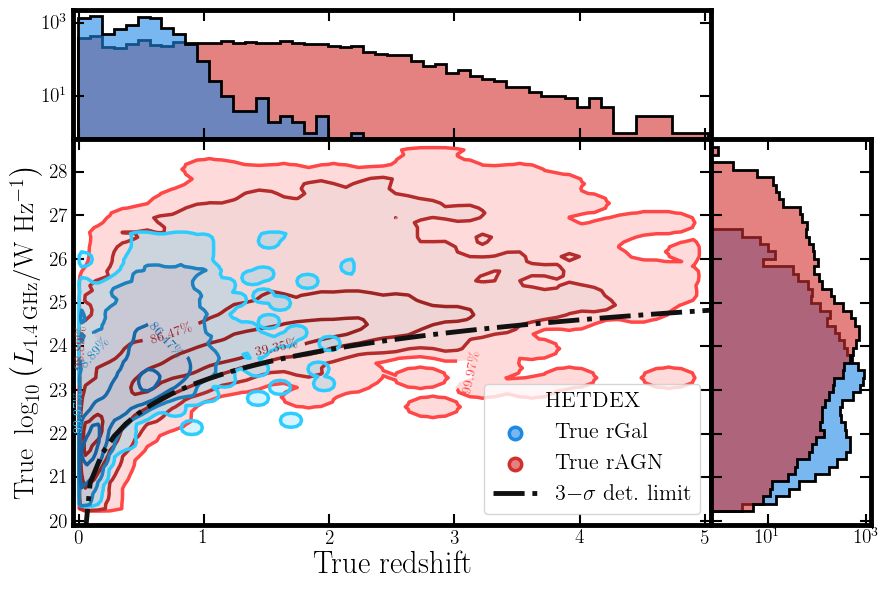

In [58]:
fig    = plt.figure(figsize=(9, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

min_z = np.nanmin(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, true_z_col].values)
max_z = np.nanmax(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, true_z_col].values)

min_lum  = np.nanmin(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, 'true_lum_14_GHz'].values)
max_lum  = np.nanmax(full_catalog_HETDEX_df.loc[true_HETDEX_radio_filter, 'true_lum_14_GHz'].values)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(true_rGal_HETDEX_df.loc[:, true_z_col], 
                                   true_rGal_HETDEX_df.loc[:, 'log_true_lum_14_GHz'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(true_rAGN_HETDEX_df.loc[:, true_z_col], 
                                   true_rAGN_HETDEX_df.loc[:, 'log_true_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rGal, 
               color=colour_rGal_shade, s=80, 
               label='$\mathrm{True ~ rGal}$', linewidths=2.5)
axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, 
               color=colour_rAGN_shade, s=80, 
               label='$\mathrm{True ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, 
            np.log10((radio_lum(sigma_limit_HETDEX * limit_flux_HETDEX * u.Jy, bins_z, radio_alpha) * ((1.4 * u.GHz) / (144 * u.MHz).to(u.GHz))**radio_alpha).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_HETDEX} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(true_rGal_HETDEX_df.loc[:, true_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2, zorder=1)
axs[0].hist(true_rAGN_HETDEX_df.loc[:, true_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2, zorder=0)

axs[2].hist(np.log10(true_rGal_HETDEX_df.loc[:, 'true_lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(np.log10(true_rAGN_HETDEX_df.loc[:, 'true_lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=r'$\mathrm{HETDEX}$', title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{True ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\mathrm{True} ~ \log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=19.9, top=28.75)
axs[1].set_xlim(left=-0.05, right=5.05)
plt.tight_layout()
plt.show()

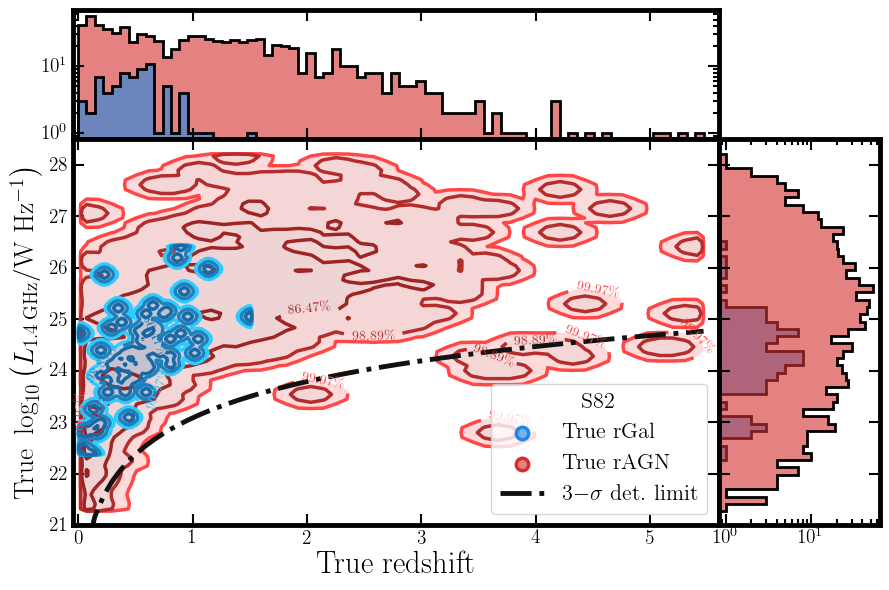

In [59]:
fig    = plt.figure(figsize=(9, 6))
# ax1    = fig.add_subplot(111, yscale='log')


grid   = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4, 1],
                          height_ratios=[1, 3], hspace=0.0, wspace=0.0)
axs    = {}
axs[0] = fig.add_subplot(grid[0, 0], yscale='log')
axs[1] = fig.add_subplot(grid[1, 0], yscale='linear', sharex=axs[0])
axs[2] = fig.add_subplot(grid[1, 1], xscale='log', yscale='linear', sharey=axs[1])

min_z = np.nanmin(full_catalog_S82_df.loc[true_S82_radio_filter, true_z_col].values)
max_z = np.nanmax(full_catalog_S82_df.loc[true_S82_radio_filter, true_z_col].values)

min_lum  = np.nanmin(full_catalog_S82_df.loc[true_S82_radio_filter, 'true_lum_14_GHz'].values)
max_lum  = np.nanmax(full_catalog_S82_df.loc[true_S82_radio_filter, 'true_lum_14_GHz'].values)

n_bins   = [50, 75]

bins_z   = np.linspace(min_z, max_z, n_bins[1])
# bins_lum = np.logspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])
bins_lum = np.linspace(np.log10(min_lum), np.log10(max_lum), n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891, 0.99966454]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3, 4 sigma (2-dimensional)

H_rGal, xedges_rGal, yedges_rGal = np.histogram2d(true_rGal_S82_df.loc[:, true_z_col], 
                                   true_rGal_S82_df.loc[:, 'log_true_lum_14_GHz'], bins=n_bins)
H_rAGN, xedges_rAGN, yedges_rAGN = np.histogram2d(true_rAGN_S82_df.loc[:, true_z_col], 
                                   true_rAGN_S82_df.loc[:, 'log_true_lum_14_GHz'], bins=n_bins)

H_rAGN_smooth = clean_and_smooth_matrix(H_rAGN, sigma=0.9)
H_rGal_smooth = clean_and_smooth_matrix(H_rGal, sigma=0.9)

Z_rAGN = (H_rAGN_smooth.T - H_rAGN_smooth.T.min())/(H_rAGN_smooth.T.max() - H_rAGN_smooth.T.min())
Z_rGal = (H_rGal_smooth.T - H_rGal_smooth.T.min())/(H_rGal_smooth.T.max() - H_rGal_smooth.T.min())

# fix probable lines not closing
# Z_rAGN = make_borders_zero(Z_rAGN)
# Z_rGal = make_borders_zero(Z_rGal)
Z_rAGN, x_centers_rAGN, y_centers_rAGN = pad_matrix_zeros(Z_rAGN, xedges_rAGN, yedges_rAGN)
Z_rGal, x_centers_rGal, y_centers_rGal = pad_matrix_zeros(Z_rGal, xedges_rGal, yedges_rGal)

CS_rAGN_f = axs[1].contourf(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rAGN(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rAGN = axs[1].contour(x_centers_rAGN, y_centers_rAGN, Z_rAGN, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rAGN(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rAGN, CS_rAGN.levels, inline=True, fmt=fmt, fontsize=10)

CS_rGal_f = axs[1].contourf(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_rGal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_rGal = axs[1].contour(x_centers_rGal, y_centers_rGal, Z_rGal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_rGal(seq_cont[::-1]), linewidths=2.5)
for count in np.arange(1):  # times to run next command, more labels
    axs[1].clabel(CS_rGal, CS_rGal.levels, inline=True, fmt=fmt, fontsize=10)

axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rGal, 
               color=colour_rGal_shade, s=80, 
               label='$\mathrm{True ~ rGal}$', linewidths=2.5)
axs[1].scatter([-1], [10], marker='o', edgecolor=colour_rAGN, 
               color=colour_rAGN_shade, s=80, 
               label='$\mathrm{True ~ rAGN}$', linewidths=2.5)


axs[1].plot(bins_z, 
            np.log10((radio_lum(sigma_limit_S82 * limit_flux_S82 * u.Jy, bins_z, radio_alpha) * ((1.4 * u.GHz) / (144 * u.MHz).to(u.GHz))**radio_alpha).value), 
            ls='-.', marker=None, color='k', label=rf'${sigma_limit_S82} {{-}} \sigma ~ \mathrm{{det. ~ limit}}$', lw=3.5)

axs[0].hist(true_rGal_S82_df.loc[:, true_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2, zorder=1)
axs[0].hist(true_rAGN_S82_df.loc[:, true_z_col], bins=bins_z, 
            histtype='stepfilled', fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2, zorder=0)

axs[2].hist(np.log10(true_rGal_S82_df.loc[:, 'true_lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rGal_shade, ec=(0, 0, 0, 1), lw=2)
axs[2].hist(np.log10(true_rAGN_S82_df.loc[:, 'true_lum_14_GHz']), bins=bins_lum, orientation='horizontal', histtype='stepfilled', 
            fc=colour_rAGN_shade, ec=(0, 0, 0, 1), lw=2)

axs[1].legend(loc='lower right', fontsize=16, title=r'$\mathrm{S82}$', title_fontsize=16)
axs[1].set_xlabel(r'$\mathrm{True ~ redshift}$', fontsize=22)
axs[1].set_ylabel(r'$\mathrm{True} ~ \log_{10}\left( L_{1.4\,\mathrm{GHz}} / \mathrm{W ~ Hz^{-1}} \right)$', fontsize=20)
for ax_count in [0, 1, 2]:
    axs[ax_count].tick_params(which='both', top=True, right=True, direction='in')
    axs[ax_count].tick_params(axis='both', which='major', labelsize=14)
    axs[ax_count].tick_params(which='major', length=8, width=1.5)
    axs[ax_count].tick_params(which='minor', length=4, width=1.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
    plt.setp(axs[ax_count].spines.values(), linewidth=3.5)
plt.setp(axs[2].get_yticklabels(), visible=False)
axs[1].set_ylim(bottom=21.0, top=28.5)
axs[1].set_xlim(left=-0.05, right=5.60)
plt.tight_layout()
plt.show()

Select galaxies with radio luminosity higher than $10^{24} ~ \mathrm{W ~ Hz^{-1}}$

In [60]:
bright_rGal_HETDEX_filter = np.array(true_rGal_HETDEX_df.loc[:, 'log_true_lum_14_GHz'] > 24)
bright_rGal_S82_filter    = np.array(true_rGal_S82_df.loc[:, 'log_true_lum_14_GHz'] > 24)

In [61]:
n_bright_rGal_HETDEX = np.nansum(bright_rGal_HETDEX_filter)
n_bright_rGal_S82    = np.nansum(bright_rGal_S82_filter)

In [62]:
print(f'There are {len(bright_rGal_HETDEX_filter)} radio galaxies in HETDEX, {n_bright_rGal_HETDEX} with high luminosities')
print(f'There are {len(bright_rGal_S82_filter)} radio galaxies in S82, {n_bright_rGal_S82} with high luminosities')

There are 9853 radio galaxies in HETDEX, 1543 with high luminosities
There are 71 radio galaxies in S82, 50 with high luminosities


In [63]:
n_bright_rGal_HETDEX / len(bright_rGal_HETDEX_filter)

0.15660205013701411

In [64]:
n_bright_rGal_S82 / len(bright_rGal_S82_filter)

0.704225352112676

Show a sample of such soruces

In [65]:
cols_2_display_HETDEX = ['ID', 'RA_ICRS', 'DE_ICRS', 'Name', 'Z', 'band_num', 'Sint_LOFAR_non_imp', 
                  'rms_LOFAR', 'W1mproPM', 'W2mproPM', 'W3mag', 'W4mag', 'gmag', 'rmag', 
                  'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'Prob_AGN', 'Prob_radio_gal', 
                  'pred_Z_rGal', 'pred_class_cal', 'pred_radio_cal_gal', 'log_true_lum_orig', 
                  'log_true_lum_14_GHz']
cols_2_display_S82 = ['ID', 'RA_ICRS', 'DE_ICRS', 'Name', 'Z', 'band_num', 'Fint_VLAS82_non_imp', 
                  'rms_VLAS82', 'W1mproPM', 'W2mproPM', 'W3mag', 'W4mag', 'gmag', 'rmag', 
                  'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'Prob_AGN', 'Prob_radio_gal', 
                  'pred_Z_rGal', 'pred_class_cal', 'pred_radio_cal_gal', 'log_true_lum_orig', 
                  'log_true_lum_14_GHz']

In [66]:
true_rGal_HETDEX_df.loc[bright_rGal_HETDEX_filter][cols_2_display_HETDEX].sample(n=10, random_state=gv.seed)

,ID,RA_ICRS,DE_ICRS,Name,Z,band_num,Sint_LOFAR_non_imp,rms_LOFAR,W1mproPM,W2mproPM,W3mag,W4mag,gmag,rmag,imag,zmag,ymag,Jmag,Hmag,Kmag,Prob_AGN,Prob_radio_gal,pred_Z_rGal,pred_class_cal,pred_radio_cal_gal,log_true_lum_orig,log_true_lum_14_GHz
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
14560081,14560081,214.900421,55.801628,J141936.09+554805.8,0.84905,7,10.900000,0.09,18.313999,18.743000,16.67,14.62,23.299999,23.200001,21.055201,20.231001,19.805799,17.450001,17.240000,16.59,0.011412,0.147792,0.8097,0,0,25.500444,24.710231
11196405,11196405,180.839722,55.139103,J120321.54+550820.8,0.51276,9,40.000000,0.18,17.959000,18.543001,16.67,14.62,21.744499,20.457001,19.687099,19.442801,19.135401,17.450001,17.240000,16.59,0.012361,0.109629,0.4852,0,0,25.543478,24.753265
12269501,12269501,221.911621,48.710682,J144738.78+484238.4,0.76605,8,585.400024,0.59,18.035000,18.660999,16.67,14.62,23.299999,21.835800,20.787901,20.257299,19.852400,17.450001,17.240000,16.59,0.021118,0.170941,0.5598,0,0,26.844447,26.054234
4963918,4963918,210.340683,48.717182,J140121.77+484301.8,0.61284,6,13.200000,0.06,18.701000,19.320000,16.67,14.62,23.299999,21.599300,20.723101,20.265499,19.670900,17.450001,17.240000,16.59,0.011741,0.062472,0.5988,0,0,25.276082,24.485870
10573182,10573182,194.175751,53.463482,J125642.17+532748.5,0.59253,8,11.200000,0.08,18.264999,18.992001,16.67,14.62,23.299999,21.442200,20.570499,20.120600,19.519199,17.450001,17.240000,16.59,0.011653,0.077621,0.6119,0,0,25.228581,24.438369
5106734,5106734,208.853607,48.776222,J135524.87+484634.4,0.78878,6,164.600006,0.07,18.230999,18.916000,16.67,14.62,23.299999,21.475500,20.989201,20.307600,19.880600,17.450001,17.240000,16.59,0.011607,0.151488,0.7451,0,0,26.593908,25.803696
14772837,14772837,218.964050,56.709251,J143551.37+564233.3,0.61015,8,42.099998,0.22,18.275999,18.839001,16.67,14.62,23.299999,21.385599,20.604700,20.147800,19.658701,17.450001,17.240000,16.59,0.011703,0.113558,0.6033,0,0,25.787804,24.997592
12937743,12937743,228.826523,51.232693,J151518.36+511357.7,0.96273,5,2.000000,0.09,18.178999,18.638000,16.67,14.62,23.299999,23.200001,21.253500,20.874500,20.257000,17.450001,17.240000,16.59,0.011724,0.425718,0.9204,0,1,24.895575,24.105362
11717282,11717282,226.580978,47.714424,J150619.43+474251.9,0.26598,12,29.500000,0.13,17.666000,18.021000,16.67,14.62,20.626101,19.343100,18.801701,18.534000,18.163500,17.361000,17.226999,16.59,0.014799,0.295179,0.2645,0,1,24.811554,24.021341


In [67]:
true_rGal_S82_df.loc[bright_rGal_S82_filter][cols_2_display_S82].sample(n=10, random_state=gv.seed)

,ID,RA_ICRS,DE_ICRS,Name,Z,band_num,Fint_VLAS82_non_imp,rms_VLAS82,W1mproPM,W2mproPM,W3mag,W4mag,gmag,rmag,imag,zmag,ymag,Jmag,Hmag,Kmag,Prob_AGN,Prob_radio_gal,pred_Z_rGal,pred_class_cal,pred_radio_cal_gal,log_true_lum_orig,log_true_lum_14_GHz
index,,,,,,,,,,,,,,,,,,,,,,,,,,,
971809,971809,19.379120,-0.631281,J011730.98-003752.5,0.53033,8,1.38,0.067,18.452000,19.230000,16.670,14.62,23.299999,21.228100,20.364000,19.898899,19.536900,17.450001,17.24,16.59,0.011852,0.055230,0.5558,0,0,24.221813,24.221813
3412950,3412950,16.880289,1.240615,J010731.26+011426.2,0.79380,8,0.79,0.065,18.273001,18.995001,16.670,14.62,23.299999,22.124701,20.949900,20.412001,19.850300,17.450001,17.24,16.59,0.011528,0.146215,0.7614,0,0,24.297849,24.297849
2426060,2426060,12.761888,0.478688,J005102.85+002843.3,0.80185,9,0.78,0.054,17.964001,17.997000,16.271,14.62,21.675400,21.187700,20.315800,19.728001,19.974199,17.450001,17.24,16.59,0.699175,0.836301,0.7217,1,1,24.152435,24.152435
3475980,3475980,15.261314,1.300775,J010102.71+011802.7,0.58455,6,3.16,0.095,18.374001,19.091000,16.670,14.62,23.299999,21.624399,20.730301,20.280199,19.851101,17.450001,17.24,16.59,0.011569,0.078535,0.6413,0,0,24.728919,24.728919
1516636,1516636,348.256836,-0.220267,J231301.64-001312.9,0.59120,8,0.76,0.053,18.125999,18.816999,16.670,14.62,23.299999,21.373501,20.384501,19.558300,19.544399,17.450001,17.24,16.59,0.011670,0.112280,0.6923,0,0,24.190535,24.190535
3498045,3498045,338.064789,1.324025,J223215.54+011926.5,0.64945,8,13.40,0.151,18.454000,18.830000,16.670,14.62,23.299999,21.739599,20.806801,20.691999,19.937000,17.450001,17.24,16.59,0.016819,0.157525,0.5774,0,0,25.242463,25.242463
2041411,2041411,336.860504,0.183160,J222726.51+001059.4,0.22473,9,6.79,0.127,18.760000,18.425001,16.670,14.62,20.601700,20.199600,20.195200,20.249500,20.210899,17.450001,17.24,16.59,0.988810,0.241283,0.9480,1,1,25.871840,25.871840
2026448,2026448,28.723885,0.171661,J015453.73+001018.0,0.65545,8,1.80,0.088,17.778000,18.455999,16.670,14.62,23.299999,21.394501,20.356400,19.788700,19.616899,17.450001,17.24,16.59,0.011801,0.189233,0.6578,0,0,24.507511,24.507511
2808891,2808891,345.574280,0.768938,J230217.82+004608.2,0.40473,12,3.11,0.066,17.438999,18.002001,16.670,14.62,21.560900,20.130800,19.437700,19.045601,18.788401,17.450001,17.24,16.59,0.012540,0.288229,0.4459,0,1,24.353270,24.353270


Plot odd sources in colour-colour diagrams

In [68]:
filter_imputed_HETDEX = np.array(true_rGal_HETDEX_df.loc[:, 'W1mproPM'] != mag_cols_lim['W1mproPM']) &\
                        np.array(true_rGal_HETDEX_df.loc[:, 'W2mproPM'] != mag_cols_lim['W2mproPM']) &\
                        np.array(true_rGal_HETDEX_df.loc[:, 'gmag']     != mag_cols_lim['gmag']) &\
                        np.array(true_rGal_HETDEX_df.loc[:, 'rmag']     != mag_cols_lim['rmag'])

filter_valid_cols_HETDEX  = np.isfinite(true_rGal_HETDEX_df.loc[:, 'W1mproPM'] - true_rGal_HETDEX_df.loc[:, 'W2mproPM']) &\
                            np.isfinite(true_rGal_HETDEX_df.loc[:, 'gmag'] - true_rGal_HETDEX_df.loc[:, 'rmag'])

filter_used_data_HETDEX      = filter_valid_cols_HETDEX & filter_imputed_HETDEX

In [79]:
np.sum(filter_used_data_HETDEX)

6864

In [80]:
np.sum(bright_rGal_HETDEX_filter)

1543

In [81]:
np.sum(filter_used_data_HETDEX & bright_rGal_HETDEX_filter)

705

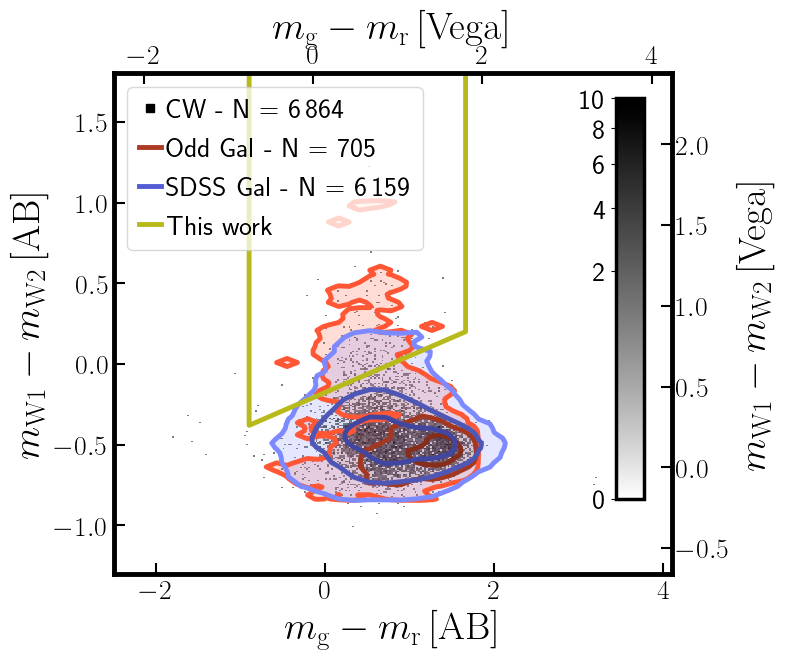

In [83]:
fig                = plt.figure(figsize=(7.2,6.5))
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')

num_levels_dens    = 20

AB_lims_x          = (-2.5, 4.1)
AB_lims_y          = (-1.3, 1.8)

try:
    norm_dens = ImageNormalize(vmin=0, vmax=10, stretch=PowerStretch(0.35))
except:
    pass

dens_plot_data_x = (true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'gmag'] -
                        true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'rmag'])
dens_plot_data_y = (true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'W1mproPM'] -
                        true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'W2mproPM'])

_, _, _, dens_CW_HETDEX = ax1.hist2d(dens_plot_data_x, dens_plot_data_y, 
                                     bins=[400, 250], cmin=1, norm=norm_dens, 
                                     cmap=plt.get_cmap(gv.cmap_dens_plots), zorder=0)
n_sources_CW     = np.nansum(filter_used_data_HETDEX)

min_X  = np.nanmin(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'g_r'])
max_X  = np.nanmax(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'g_r'])
min_Y  = np.nanmin(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'W1_W2'])
max_Y  = np.nanmax(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX, 'W1_W2'])
n_bins = [50, 75]
bins_X = np.linspace(min_X, max_X, n_bins[1])
bins_Y = np.linspace(min_Y, max_Y, n_bins[0])

sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc_inv = [1. - sigma for sigma in sigmas_perc][::-1]  # 1, 2, 3 sigma (2-dimensional)

nstep = 4
seq_cont   = np.logspace(-1.5, 0.0, nstep)
seq_cont   = np.insert(seq_cont, 0, 0.0)
seq_fill   = np.logspace(-1.5, 0.0, nstep+2)
seq_fill   = np.insert(seq_fill, 0, 0.0)

cm_gradient_odd = create_colour_gradient(mcolors.to_hex(plt.get_cmap(gv.cmap_hists)(0.2)))
cm_gradient_Gal = create_colour_gradient(mcolors.to_hex(plt.get_cmap(gv.cmap_hists)(0.8)))

H_odd, xedges_odd, yedges_odd = np.histogram2d(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX & bright_rGal_HETDEX_filter, 'g_r'], 
                                   true_rGal_HETDEX_df.loc[filter_used_data_HETDEX & bright_rGal_HETDEX_filter, 'W1_W2'], bins=n_bins)
H_Gal, xedges_Gal, yedges_Gal = np.histogram2d(true_rGal_HETDEX_df.loc[filter_used_data_HETDEX & ~bright_rGal_HETDEX_filter, 'g_r'], 
                                   true_rGal_HETDEX_df.loc[filter_used_data_HETDEX & ~bright_rGal_HETDEX_filter, 'W1_W2'], bins=n_bins)

H_odd_smooth = clean_and_smooth_matrix(H_odd, sigma=0.9)
H_Gal_smooth = clean_and_smooth_matrix(H_Gal, sigma=0.9)

Z_odd = (H_odd_smooth.T - H_odd_smooth.T.min())/(H_odd_smooth.T.max() - H_odd_smooth.T.min())
Z_Gal = (H_Gal_smooth.T - H_Gal_smooth.T.min())/(H_Gal_smooth.T.max() - H_Gal_smooth.T.min())

# fix probable lines not closing
Z_odd, x_centers_odd, y_centers_odd = pad_matrix_zeros(Z_odd, xedges_odd, yedges_odd)
Z_Gal, x_centers_Gal, y_centers_Gal = pad_matrix_zeros(Z_Gal, xedges_Gal, yedges_Gal)

CS_odd_f = ax1.contourf(x_centers_odd, y_centers_odd, Z_odd, levels=sigmas_perc_inv, 
                            colors=cm_gradient_odd(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_odd = ax1.contour(x_centers_odd, y_centers_odd, Z_odd, levels=sigmas_perc_inv, 
                         colors=cm_gradient_odd(seq_cont[::-1]), linewidths=3.5)
for count in np.arange(0):  # times to run next command, more labels
    labels_odd = ax1.clabel(CS_odd, CS_odd.levels, inline=True, fmt=gf.fmt, 
                            fontsize=10, inline_spacing=-8)
    [txt.set_bbox(dict(boxstyle='square, pad=0', fc='None', ec='None')) for txt in labels_odd]

CS_Gal_f = ax1.contourf(x_centers_Gal, y_centers_Gal, Z_Gal, levels=sigmas_perc_inv, 
                            colors=cm_gradient_Gal(seq_fill[::-1]), extend='max', 
                            alpha=0.2, antialiased=True)
CS_Gal = ax1.contour(x_centers_Gal, y_centers_Gal, Z_Gal, levels=sigmas_perc_inv, 
                         colors=cm_gradient_Gal(seq_cont[::-1]), linewidths=3.5)
for count in np.arange(0):  # times to run next command, more labels
    labels_Gal = ax1.clabel(CS_Gal, CS_Gal.levels, inline=True, fmt=gf.fmt, 
                            fontsize=10, inline_spacing=-8)
    [txt.set_bbox(dict(boxstyle='square, pad=0', fc='None', ec='None')) for txt in labels_Gal]

ax1.plot([-3], [-3], marker='s', ls='None', c=plt.get_cmap(gv.cmap_dens_plots)(1.1), 
        label=f'CW          -  N = {n_sources_CW:,}'.replace(',','$\,$'), zorder=0)
ax1.plot([-3], [-3], marker=None, ls='-', lw=3.5, c=plt.get_cmap(gv.cmap_hists)(0.2), 
        label=f'Odd Gal - N =      {np.sum(filter_used_data_HETDEX & bright_rGal_HETDEX_filter):,}'.replace(',','$\,$'), zorder=0)
ax1.plot([-3], [-3], marker=None, ls='-', lw=3.5, c=plt.get_cmap(gv.cmap_hists)(0.8), 
        label=f'SDSS Gal  - N =      {np.sum(filter_used_data_HETDEX & ~bright_rGal_HETDEX_filter):,}'.replace(',','$\,$'), zorder=0)

# Colorbar density
axins0 = inset_axes(ax1, width='100%', height='100%', bbox_transform=ax1.transAxes,
                    loc=1, bbox_to_anchor=(0.9, 0.15, 0.05, 0.80), borderpad=0)
clb_dens    = fig.colorbar(dens_CW_HETDEX, cax=axins0, orientation='vertical', 
                           cmap=plt.get_cmap(gv.cmap_dens_plots, num_levels_dens), 
                           norm=norm_dens, extend='neither', 
                           format=lambda x, pos: f"{x:,.0f}".replace(",", "$\,$"))
axins0.yaxis.set_ticks_position('left')
clb_dens.ax.tick_params(labelsize=20)
clb_dens.outline.set_linewidth(2.5)
# clb_dens.ax.set_ylabel('Elements per pixel', size=12, path_effects=pe2)

ax1.set_xlim(AB_lims_x)
ax1.set_ylim(AB_lims_y)

x_Vega   = np.array(AB_lims_x) - vega_shift['gmag']     + vega_shift['rmag']      # Vega
y_Vega   = np.array(AB_lims_y) - vega_shift['W1mproPM'] + vega_shift['W2mproPM']  # Vega
# New criterion by Carvajal+
points_C23 = np.array([[-0.76, -0.76, 1.8, 1.8], [y_Vega[-1], 0.26, 0.84, y_Vega[-1]]])
ax1.plot(points_C23[0] + vega_shift['gmag'] - vega_shift['rmag'], 
        points_C23[1] + vega_shift['W1mproPM'] - vega_shift['W2mproPM'], 
        label='This work', c=plt.get_cmap(gv.cmap_bands)(0.75), zorder=2, lw=3.5)

ax2 = ax1.twinx()
ax2.set_ylim(tuple(np.array(ax1.get_ylim()) - 2.699 + 3.339))
ax2.tick_params(which='both', top=False, right=True, direction='in')
ax2.tick_params(which='both', bottom=False, left=False, direction='in')
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
ax2.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[Vega]}$', size=28)

ax3 = ax1.twiny()
ax3.set_xlim(tuple(np.array(ax1.get_xlim()) - 0.481 + 0.617))
ax3.tick_params(which='both', top=True, right=False, direction='in')
ax3.tick_params(which='both', bottom=False, left=False, direction='in')
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(which='major', length=8, width=1.5)
ax3.tick_params(which='minor', length=4, width=1.5)
ax3.set_xlabel('$m_{\mathrm{g}} - m_{\mathrm{r}}\, \mathrm{[Vega]}$', size=28)

ax1.tick_params(which='both', top=False, right=False, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('$m_{\mathrm{g}} - m_{\mathrm{r}}\, \mathrm{[AB]}$', size=28)
ax1.set_ylabel('$m_{\mathrm{W1}} - m_{\mathrm{W2}}\, \mathrm{[AB]}$', size=28)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc=2, fontsize=20, ncol=1, columnspacing=.5, handletextpad=0.2, handlelength=0.8, framealpha=0.75)
# plt.tight_layout()
plt.show()